# Tutorial 5: Diffusion-based multimodal exploration of subtrajectories

Tutorials 4 and 5 study a human bone marrow dataset by [Mimitou et al., 2021](https://www.nature.com/articles/s41587-021-00927-2) showing the differentiation of hematopoietic stem cells to multiple developmental fates.

Building developmental single-cell atlases involves refined analysis of developmental subtrajectories from data consisting of multiple distinct lineages and cell types unrelated directly to a subtrajectory of interest. Typically, such analysis entails clustering all cells, manual annotation of cell clusters, and supervised extraction of cell clusters that may belong to the studied subtrajectory. In this tutorial, you will select a cell subpopulation and apply a multimodal diffusion process to trace trajectories related to it using Ocelli.

## Loading data

Download data available on [figshare](https://doi.org/10.6084/m9.figshare.22700062.v1).

In [1]:
! wget --content-disposition https://figshare.com/ndownloader/articles/22700062/versions/3
! unzip -o 22700062.zip
! rm 22700062.zip

--2023-10-05 11:36:45--  https://figshare.com/ndownloader/articles/22700062/versions/3
Resolving figshare.com (figshare.com)... 52.49.59.79, 34.248.41.179, 2a05:d018:1f4:d003:63e2:30d7:6063:c9d7, ...
Connecting to figshare.com (figshare.com)|52.49.59.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37581583 (36M) [application/zip]
Saving to: ‘22700062.zip’

22700062.zip        100%[===================>]  35.84M  13.3MB/s    in 2.7s    

2023-10-05 11:36:48 (13.3 MB/s) - ‘22700062.zip’ saved [37581583/37581583]

Archive:  22700062.zip
 extracting: human_bone_marrow_atac.h5ad  
 extracting: human_bone_marrow_atac_hscs.h5ad  
 extracting: human_bone_marrow_prot.h5ad  
 extracting: human_bone_marrow_prot_hscs.h5ad  


Prepare data as in tutorial 4.

In [2]:
import anndata as ad
import ocelli as oci
from scipy.sparse import csr_matrix

atac = ad.read_h5ad('human_bone_marrow_atac.h5ad')
prot = ad.read_h5ad('human_bone_marrow_prot.h5ad')

# create a joint AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(10927, 1)))

adata.obsm['atac'] = atac.obsm['X_lda']
adata.obsm['prot'] = prot.obsm['X_lda']
adata.uns['modalities'] = ['atac', 'prot']

adata.obs.index = list(atac.obs.index)
adata.obs['celltype'] = list(atac.obs['celltype'])

## Multimodal Diffusion Maps

Repeat the MDM training procedure from tutorial 4. For multimodal diffusion in later steps, Ocelli needs eigenvectors and eigenvalues of the multimodal Markov matrix. To save them in the `adata` object, set `save_eigvec=True` and `save_eigval=True`.

In [3]:
oci.pp.neighbors(adata, n_neighbors=70, verbose=True)
oci.tl.weights(adata, random_state=17, verbose=True)
oci.tl.MDM(adata, n_components=10, random_state=17, save_eigvec=True, 
           save_eigval=True, verbose=True)

oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=20, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=20, verbose=True)
oci.tl.FA2(adata, n_components=2, random_state=142, n_iter=20000,
           linlogmode=True, flags='--jitterTolerance 0.1 --scalingRatio 0.01 '\
           '--outboundAttractionDistribution true')

[atac]	70 nearest neighbors calculated.
[prot]	70 nearest neighbors calculated.


2023-10-05 11:36:57,487	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-10-05 11:37:05,711	INFO worker.py:1518 -- Started a local Ray instance.


[atac]	Unimodal Markov chain calculated.
[prot]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.
[X_mdm]	20 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Oct 05, 2023 11:37:34 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 05, 2023 11:37:35 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 10,927 (10,927 added)
Oct 05, 2023 11:37:35 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 218,540 (143,249 added)


***********

**************25%
*************************50%
*************************75%
*************************100%
Time = 289.61s


## Multimodal diffusion of hematopoietic stem cells

In this section, you will explore developmental trajectories around hematopoietic stem cells (HSCs). To do so:
- create a vector with 1s assigned to HSCs and 0s to all other cells,
- run the multimodal diffusion to monitor the spread of local trajectories.

First, recall where HSCs are located.

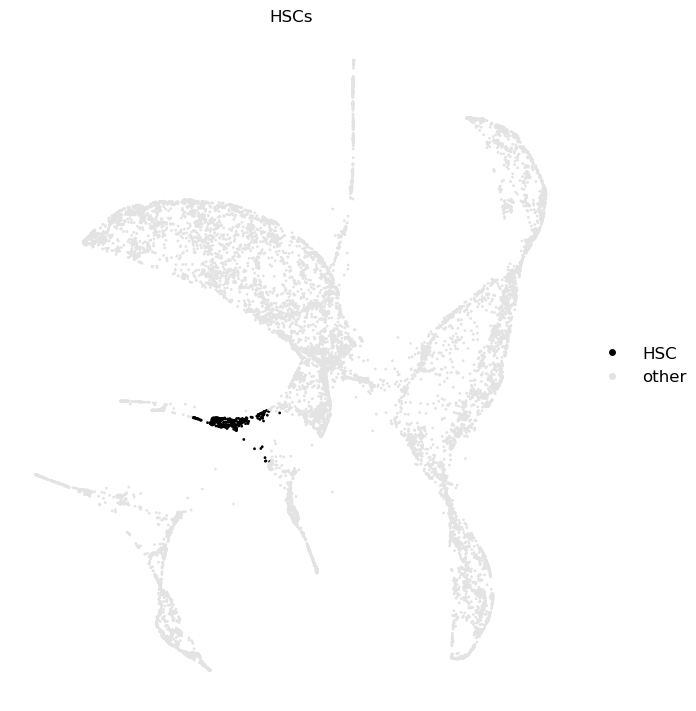

In [4]:
adata.obs['HSCs'] = ['HSC' if val == 'HSCs' else 'other' for val in adata.obs['celltype']]

oci.pl.scatter(adata, x='X_fa2', c='HSCs', cdict={'HSC': 'black', 'other': '#e3e3e3'}, 
               figsize=(7, 7), markersize=4, fontsize=12)

Create a vector with 1s assigned to HSCs and 0s to all other cells. Then, create an AnnData object `adata_diff` with this vector as `adata_diff.X`.

In [5]:
import numpy as np

d = {'HSC': 1, 'other': 0}

adata_diff = ad.AnnData(np.asarray([[d[v]] for v in adata.obs.HSCs]))

# add eigenvetors, eigenvalues and 2D embedding to the AnnData object
adata_diff.uns['eigenvalues'] = adata.uns['eigenvalues']
adata_diff.uns['eigenvectors'] = adata.uns['eigenvectors']
adata_diff.obsm['X_fa2'] = adata.obsm['X_fa2']

adata_diff

AnnData object with n_obs × n_vars = 10927 × 1
    uns: 'eigenvalues', 'eigenvectors'
    obsm: 'X_fa2'

Now you can run multimodal diffusion on `adata_diff`. Do it for multiple steps `t` to see how the trajectory signal propagates.

In [6]:
for t in [1, 10, 20]:
    # create a adata_diff copy not to overwrite its data
    adata_diff_copy = adata_diff.copy()
    
    # run the diffusion with selected t
    oci.tl.imputation(adata_diff_copy, t=t)
    
    # save the diffusion output
    adata_diff.obs['diff_t{}'.format(t)] = adata_diff_copy.X

Plot the diffused signal at `t=1`, `t=10`, and `t=20`.

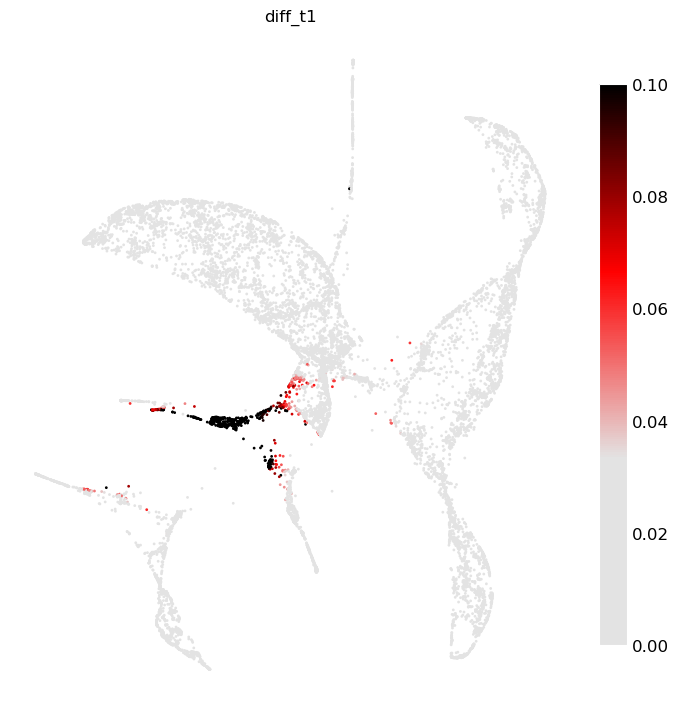

In [7]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

oci.pl.scatter(adata_diff, x='X_fa2', c='diff_t1', cmap=cmap,
               figsize=(7, 7), markersize=4, fontsize=12, vmin=0, vmax=0.1)

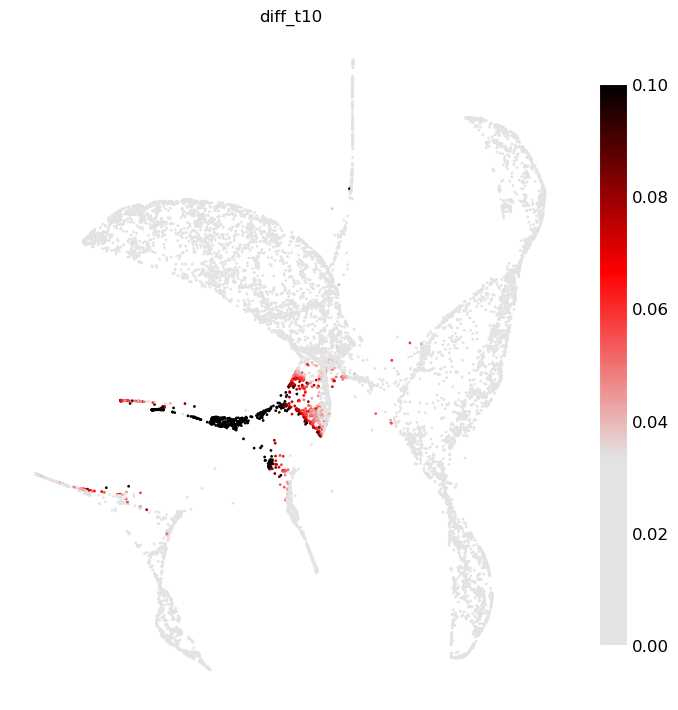

In [8]:
oci.pl.scatter(adata_diff, x='X_fa2', c='diff_t10', cmap=cmap,
               figsize=(7, 7), markersize=4, fontsize=12, vmin=0, vmax=0.1)

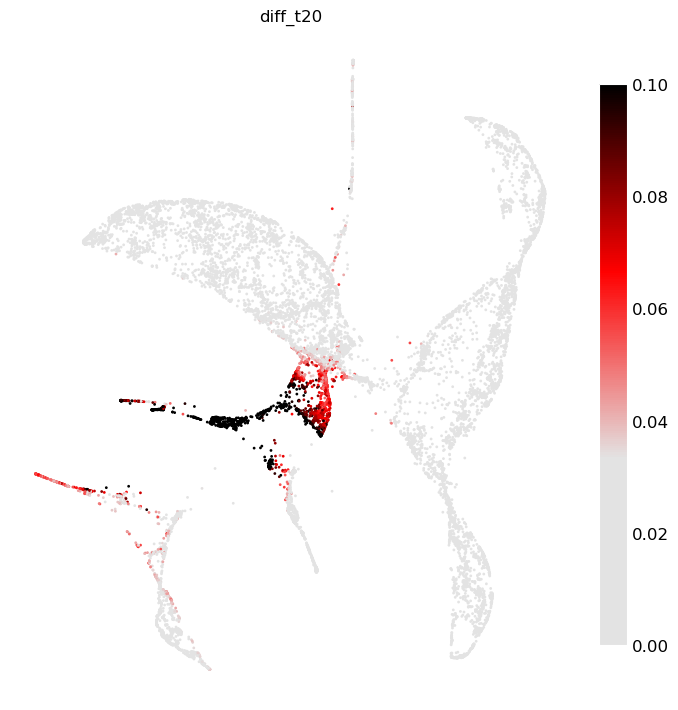

In [9]:
oci.pl.scatter(adata_diff, x='X_fa2', c='diff_t20', cmap=cmap,
               figsize=(7, 7), markersize=4, fontsize=12, vmin=0, vmax=0.1)

In order to examine only trajectories around HSCs, select cells in close developmental proximity to HSCs.

In [10]:
# select cells which had a high diffused signal and t=20
adata_diff = adata_diff[adata_diff.obs['diff_t20'] > 0.055]

adata_diff

View of AnnData object with n_obs × n_vars = 1451 × 1
    obs: 'diff_t1', 'diff_t10', 'diff_t20'
    uns: 'eigenvalues', 'eigenvectors'
    obsm: 'X_fa2'

This results in 1,451 cells. Load the raw data for this subset and generate a new multimodal embedding to explore trajectories at a higher resolution.

## Finding subtrajectories around HSCs

Compute the MDM embedding. Load raw data and find LDA embeddings of both modalities. For simplicity, we provide annotated matrices with precomputed topics.

In [11]:
#atac = ad.read_h5ad('human_bone_marrow_atac.h5ad')[adata_diff.obs.index]
#oci.pp.LDA(atac, n_components=15, max_iter=30, random_state=17, verbose=1)

#prot = ad.read_h5ad('human_bone_marrow_prot.h5ad')[adata_diff.obs.index]
#oci.pp.LDA(prot, n_components=15, max_iter=30, random_state=17, verbose=1)

atac = ad.read_h5ad('human_bone_marrow_atac_hscs.h5ad')
prot = ad.read_h5ad('human_bone_marrow_prot_hscs.h5ad')

# create a joint AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(atac.shape[0], 1000)))
adata.obsm['atac'] = atac.obsm['X_lda']
adata.obsm['prot'] = prot.obsm['X_lda']
adata.uns['modalities'] = ['atac', 'prot']
adata.obs.index = list(atac.obs.index)

# run MDM
oci.pp.neighbors(adata, n_neighbors=50, verbose=True)
oci.tl.weights(adata, random_state=17, verbose=True)
oci.tl.MDM(adata, n_components=7, random_state=17, verbose=True, save_mmc=True)

# create a 3D ForceAtlas2 embedding and project it onto a 2D plane
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=50, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=50, verbose=True)
oci.tl.FA2(adata, n_components=3, random_state=17, out='X_fa2', n_iter=10000, linlogmode=True, gravity=1, 
           flags='--jitterTolerance 0.1 --scalingRatio 0.01')
oci.tl.projection(adata, x='X_fa2', phi=225, theta=45, random_state=17)

[atac]	50 nearest neighbors calculated.
[prot]	50 nearest neighbors calculated.


2023-10-05 11:42:26,572	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-10-05 11:42:31,936	INFO worker.py:1518 -- Started a local Ray instance.


[atac]	Unimodal Markov chain calculated.
[prot]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
7 Multimodal Diffusion Maps components calculated.
[X_mdm]	50 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Oct 05, 2023 11:42:42 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 05, 2023 11:42:43 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 1,451 (1,451 added)
Oct 05, 2023 11:42:43 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 72,550 (45,333 added)


*************************25%
*************************50%
*************************75%
*******

******************100%
Time = 37.953s


The new embedding shows a structure with multiple branching points and lineages.

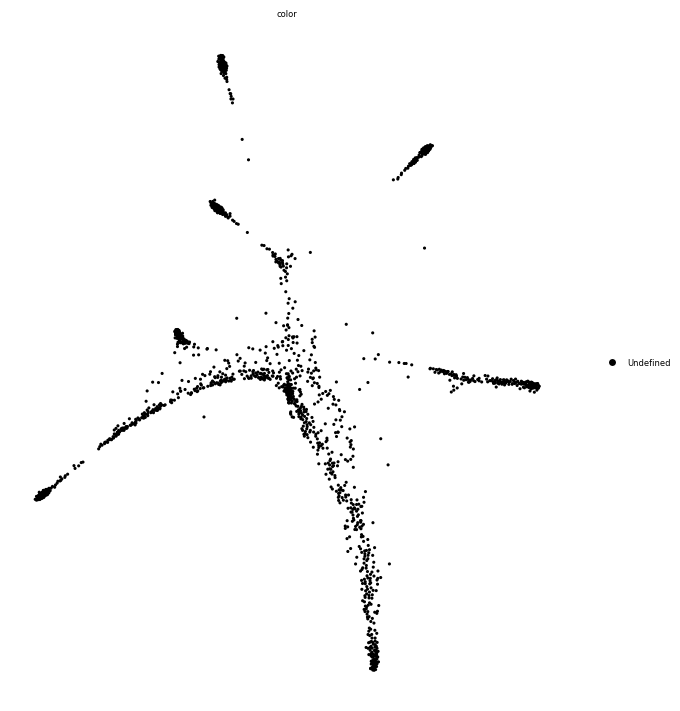

In [12]:
oci.pl.scatter(adata, x='X_proj', figsize=(7, 7), markersize=5)

To identify lineages, plot levels of selected protein markers. For example, CD71 (erythroid cells) and CD19 (B cells).

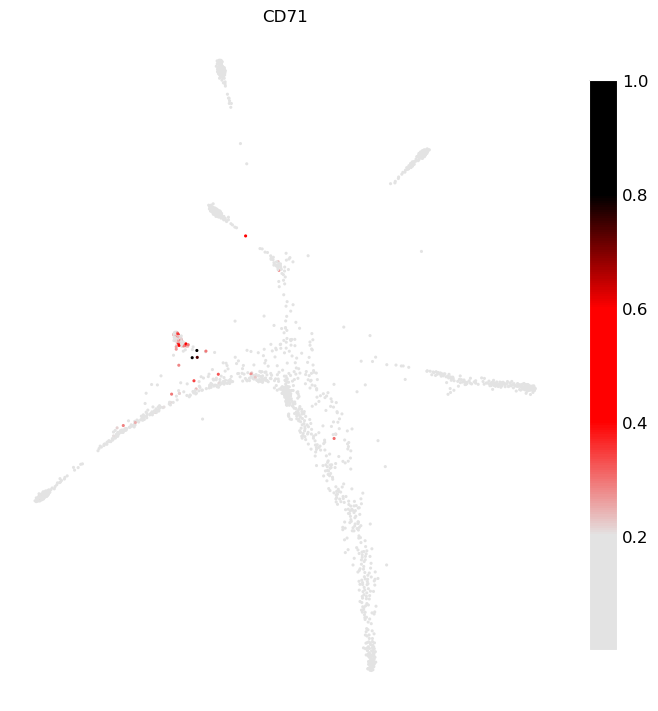

In [13]:
# a colormap for plotting
cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3', '#e3e3e3',
                                                    '#ff0000', '#ff0000', 
                                                    '#000000', '#000000'], N=256)

# save normalized protein levels to adata.obs
cd71 = prot[:, 'CD71'].X.toarray().flatten()
adata.obs['CD71'] = cd71 / np.max(cd71)

oci.pl.scatter(adata, x='X_proj', c='CD71', cmap=cmap, figsize=(7, 7), markersize=5, 
               fontsize=12)

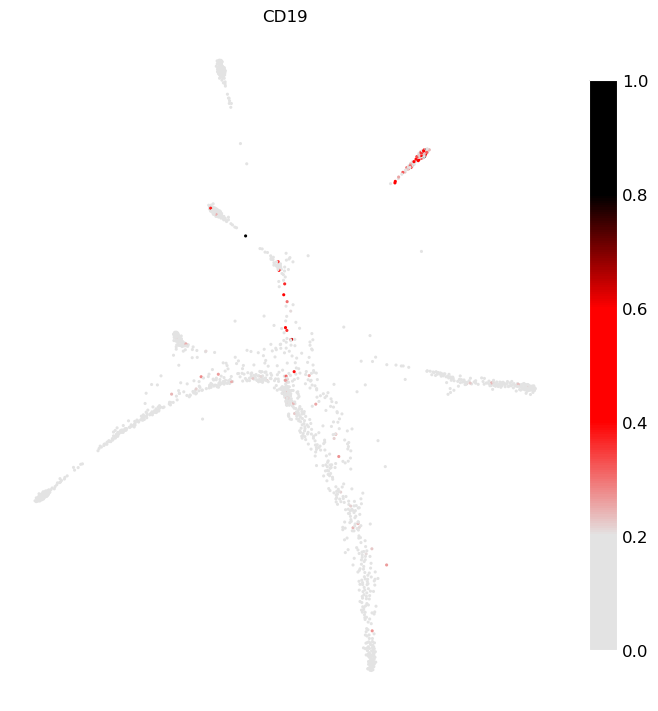

In [14]:
cd19 = prot[:, 'CD19'].X.toarray().flatten()
adata.obs['CD19'] = cd19 / np.max(cd19)

oci.pl.scatter(adata, x='X_proj', c='CD19', cmap=cmap, figsize=(7, 7), markersize=5, 
               fontsize=12)

Selection of a cell subpopulation, multimodal diffusion of its presence, and analysis of diffused trajectories allow for more accurate developmental lineage tracing.

In Tutorial 6, you will learn to use Ocelli if your data is unimodal.